## Breast Cancer Classification ##

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report

**1. Data Pre-processing**

Reading Data and creating Features and Classification splits

In [2]:
# Read the data
df = pd.read_csv('data.csv', low_memory=False)

# Split into features and target
X = df.drop('cancer_type', axis=1)
X = X.drop('patient_id', axis=1)
y = df['cancer_type']

Converting Strings into one-hot encoded data

In [3]:
def encode_categorical_cols(cols, df=X):

    for col in cols:
        df[col] = df[col].fillna("missing") # Fills NA values with a string

        df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=True) # Categorizes

        df[col] = df[col].cat.codes # Replaces strings with categories

    return df

nominal_cols =[]

# Automatically fill nominal_cols with columns containing strings that are not in ordinal_cols
for col in X.columns:
    if X[col].dtype == 'object':
        nominal_cols.append(col)

# Encode categorical columns
X = encode_categorical_cols(nominal_cols)
X = X.fillna(0)

label_encoder = LabelEncoder()

# Convert string labels to integer labels
y = label_encoder.fit_transform(y)

Normalizing data then splitting the features into train, validation, and test datasets. Then oversampling minority classes

In [4]:
# Normalizing numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
) # Splits data into 80% training and 20% testing
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True
) # Splits the 80% training into 60% training and 20% validation
print('Distribution in y_train:', np.bincount(y_train))
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train) # Oversamples minority classes

print('Distribution in y_train:', np.bincount(y_train))
print('Distribution in y_val:', np.bincount(y_val))
print('Distribution in y_test:', np.bincount(y_test))


Distribution in y_train: [719  68  11  99]
Distribution in y_train: [719 719 719 719]
Distribution in y_val: [240  23   3  33]
Distribution in y_test: [240  23   4  33]


In [5]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a Lasso Regression model
lasso = Lasso(alpha=0.015)
feature_selector = SelectFromModel(lasso)
feature_selector.fit(X_train, y_train)

# Transform the training, validation, and test data
X_train_selected = feature_selector.transform(X_train)
X_val_selected = feature_selector.transform(X_val)
X_test_selected = feature_selector.transform(X_test)

**2. DNN Model**

2.1 Building the DNN Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from kerastuner import HyperModel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential([
            Input(shape=self.input_shape),
            Dense(
                units=hp.Int('units_1', min_value=128, max_value=512, step=32),
                activation='relu',
                kernel_regularizer=l2(hp.Float('l2_1', min_value=0.0001, max_value=0.01, sampling='LOG'))
            ),
            BatchNormalization(),
            Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1)),
            Dense(
                units=hp.Int('units_2', min_value=128, max_value=512, step=32),
                activation='relu',
                kernel_regularizer=l2(hp.Float('l2_2', min_value=0.0001, max_value=0.01, sampling='LOG'))
            ),
            BatchNormalization(),
            Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1)),
            Dense(
                units=hp.Int('units_3', min_value=128, max_value=512, step=32),
                activation='relu',
                kernel_regularizer=l2(hp.Float('l2_3', min_value=0.0001, max_value=0.01, sampling='LOG'))
            ),
            BatchNormalization(),
            Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.7, step=0.1)),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [59]:
from kerastuner.tuners import Hyperband

input_shape = X_train_selected.shape[1:]
hypermodel = MyHyperModel(num_classes=len(np.unique(y)), input_shape=input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    
)

tuner.search(X_train_selected, y_train, epochs=10, validation_data=(X_val_selected, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 90 Complete [00h 00m 36s]
val_accuracy: 0.6856187582015991

Best val_accuracy So Far: 0.7792642116546631
Total elapsed time: 00h 18m 56s


units_1: 224
l2_1: 0.000182406562825328
dropout_1: 0.4
units_2: 512
l2_2: 0.004511709522511237
dropout_2: 0.4
units_3: 128
l2_3: 0.0003032990167232719
dropout_3: 0.6000000000000001
learning_rate: 0.0043925333029596605
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

      Class1       0.84      0.85      0.85       240
      Class2       0.32      0.48      0.39        23
      Class3       0.00      0.00      0.00         4
      Class4       0.17      0.12      0.14        33

    accuracy                           0.73       300
   macro avg       0.34      0.36      0.34       300
weighted avg       0.72      0.73      0.72       300


C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

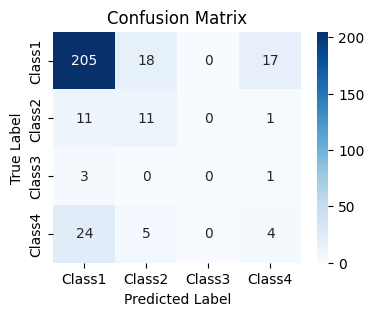

In [63]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

for hp, value in best_hyperparameters.values.items():
    print(f"{hp}: {value}")

predictions = best_model.predict(X_test_selected)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(y_test, predicted_classes, target_names=['Class1', 'Class2', 'Class3', 'Class4'])
print(report)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class1', 'Class2', 'Class3', 'Class4'], yticklabels=['Class1', 'Class2', 'Class3', 'Class4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Saving and Loading the model

In [56]:
best_model.save('Breast_Cancer_Classification_DNN_Model.keras') # To save the model

In [0]:
best_model_DNN = load_model('Breast_Cancer_Classification_DNN_Model.keras') # To load the model

Printing out the model's predictions

In [28]:
predictions = best_model.predict(X_test_selected)
predicted_classes = np.argmax(predictions, axis=1)
unique, counts = np.unique(predicted_classes, return_counts=True)
print('Distribution in y_test:', np.bincount(y_test))
print(np.asarray((unique, counts)).T)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Distribution in y_test: [240  23   4  33]
[[  0 256]
 [  1  17]
 [  2   1]
 [  3  26]]


**3. SVM**

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# initialize and train the Support Vector Machines model
svmclassifier = SVC(kernel='rbf', decision_function_shape='ovr')  # Initialize SVM with RBF kernel
svmclassifier.fit(X_train, y_train)  # Train the model with training data

# report the number of support vectors
num_support_vectors = len(svmclassifier.support_vectors_)
print("Number of support vectors:", num_support_vectors)

# predict labels for the validation set
y_pred = svmclassifier.predict(X_val)

# report the validation accuracy of the trained model
validation_accuracy = accuracy_score(y_val, y_pred)
print("Validation accuracy:", validation_accuracy)


Number of support vectors: 1845
Validation accuracy: 0.6789297658862876


C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\User

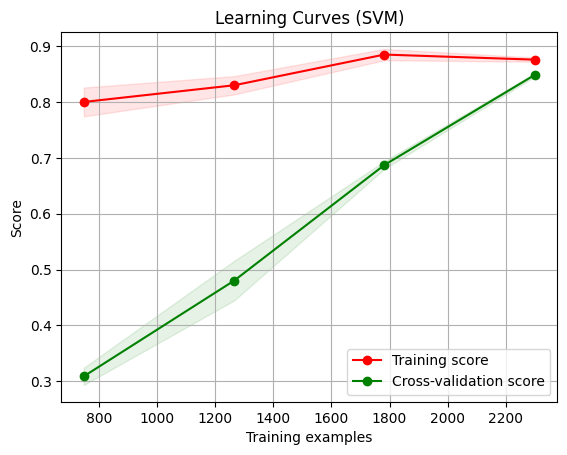

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve
title = "Learning Curves (SVM)"
cv = 5  # Use default 5-fold cross-validation
plot_learning_curve(svmclassifier, title, X_train_selected, y_train, cv=cv, n_jobs=-1)

plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svmclassifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val_selected, y_val)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best validation accuracy:", best_score)


C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best validation accuracy: 0.806045197740113


In [11]:
#Evaluating the model
# Get the best SVM model from the grid search
best_svmclassifier = grid_search.best_estimator_

# Predict labels for the test set
y_pred_test = best_svmclassifier.predict(X_test_selected)
# Calculate the accuracy of the tuned model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test accuracy of the tuned SVM model:", test_accuracy)

Test accuracy of the tuned SVM model: 0.7966666666666666


Classification Report:
              precision    recall  f1-score   support

     Class 1       0.80      0.99      0.88       240
     Class 2       0.00      0.00      0.00        23
     Class 3       0.00      0.00      0.00         4
     Class 4       0.00      0.00      0.00        33

    accuracy                           0.79       300
   macro avg       0.20      0.25      0.22       300
weighted avg       0.64      0.79      0.71       300


C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.virtualenvs\Final_Project_-_CMPS261_-_Raghead_Bahmad-3c66NncQ\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

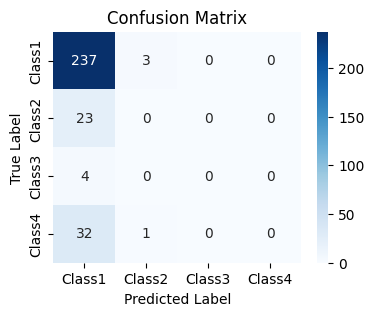

In [70]:
from sklearn.metrics import classification_report

# Generate classification report
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class1', 'Class2', 'Class3', 'Class4'], yticklabels=['Class1', 'Class2', 'Class3', 'Class4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
import pickle
# save the model to disk
filename = 'Breast_Cancer_Classification_SVM_Model.sav'
pickle.dump(best_svmclassifier, open(filename, 'wb'))

In [ ]:
best_svmclassifier = pickle.load(open(filename, 'rb')) # to load the model

**4. Gradient Boosting**

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'colsample_bytree': 0.771579057937102, 'learning_rate': 0.1459689559800492, 'max_depth': 9, 'n_estimators': 198, 'subsample': 0.8206247737671866}
Best CV Score: 0.9669747758299029
Test Accuracy: 0.7966666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       240
           1       0.23      0.13      0.17        23
           2       1.00      0.50      0.67         4
           3       0.40      0.06      0.11        33

    accuracy                           0.80       300
   macro avg       0.61      0.41      0.46       300
weighted avg       0.74      0.80      0.75       300


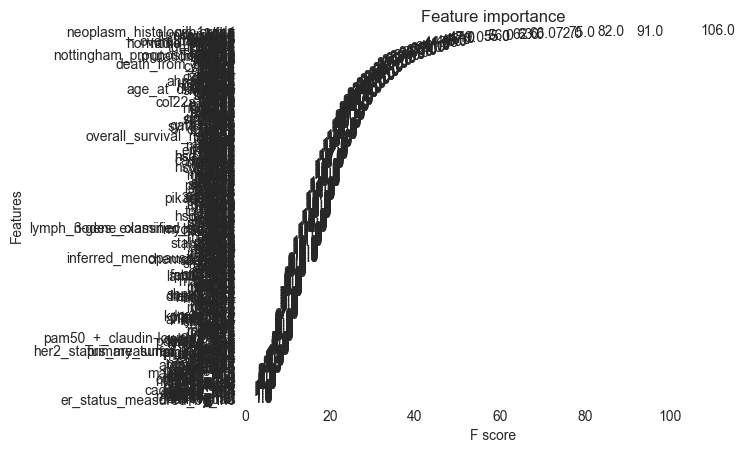

NameError: name 'confusion_matrix' is not defined

In [16]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter distributions to sample from
param_dist = {
    'max_depth': randint(3, 10),  # Random integers between 3 and 10
    'learning_rate': uniform(0.01, 0.2),  # Uniform distribution from 0.01 to 0.21
    'n_estimators': randint(100, 300),  # Random integers between 100 and 300
    'subsample': uniform(0.8, 0.2),  # Uniform distribution from 0.8 to 1.0
    'colsample_bytree': uniform(0.7, 0.3)  # Uniform distribution from 0.7 to 1.0
}

# Randomized search on hyper parameters
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best CV Score:", best_score)

# Predict and evaluate using the best estimator
y_pred_test = random_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot feature importance
plot_importance(random_search.best_estimator_, importance_type='weight')
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class1', 'Class2', 'Class3', 'Class4'], yticklabels=['Class1', 'Class2', 'Class3', 'Class4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# save the model to disk
filename = 'Breast_Cancer_Classification_XGB_Model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

In [ ]:
xgb_model = pickle.load(open(filename, 'rb')) # to load the model